<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** José Luis Almendarez González.

**Fecha:** 15 de marzo del 2025.

**Expediente** : 737807.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/MPST-2025-I/tarea-4-ejercicio-cnn-tarea-4-2



# Tarea 4: Clase 13

1.	Buscar un artículo científico donde se apliquen las CNN. Hacer una discusión y mostrar los resultados en el notebook de solución de la tarea. (Sólo se va solicitar un artículo por pareja) ✓
    
2.	Implementar todas las técnicas vistas en esta clase al siguiente dataset para predecir el precio de las viviendas:

+ https://www.kaggle.com/datasets/yasserh/housing-prices-dataset. El objetivo en este ejercicio es que usen una CNN para predecir el precio de las casas. Este dataset, ya tiene todas las características a ser usadas por el modelo, así que no tienen que realizar alguna preparación especial de los datos. Sólo buscar la mejor estructura de la CNN que les de mejores resultados.
+ https://www.kaggle.com/datasets/joebeachcapital/nsw-australia-electricity-demand-2018-2023/data. Por el contrario en este dataset ya se proporciona una serie temporal, donde el objetivo es predecir el consumo de demnada eléctrico en Australia. Con esta serie temporal, si pueden aplicar las funciones de preparación de datos para CNN como se vió en clase.



Código de solución estudiante 1

https://github.com/MPST-2025-I/tarea-4-ejercicio-cnn-tarea-4-2/blob/Francisco_branch/Plantilla_Tareas.ipynb

Código de solución estudiante 2

https://github.com/MPST-2025-I/tarea-4-ejercicio-cnn-tarea-4-2/blob/Jose-branch/Plantilla_Tareas.ipynb



In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

### Housing prices dataset

In [9]:
df = pd.read_csv("ds1/Housing.csv")
print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Data shape: (545, 13)

First few rows:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


In [10]:
print("\nColumns in the dataset:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


Columns in the dataset:
['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

Data types:
price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

Missing values:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [11]:
for col in ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
            'airconditioning', 'prefarea']:
    df[col] = df[col].map({'yes': 1, 'no': 0})

In [12]:
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

In [13]:
X = df.drop('price', axis=1)
y = df['price']

In [14]:
print(f"\nFeatures after preprocessing: {X.columns.tolist()}")
print(f"Number of features: {X.shape[1]}")


Features after preprocessing: ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']
Number of features: 13


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_original = y_test.values

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
def build_and_evaluate_model(name, model):
    """Build and evaluate a neural network model"""
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2,
            patience=10, 
            min_lr=0.00001,
            verbose=1
        )
    ]
    
    history = model.fit(
        X_train_scaled, 
        y_train,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    train_preds = model.predict(X_train_scaled).flatten()
    test_preds = model.predict(X_test_scaled).flatten()
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    print(f"\n{name} Results:")
    print(f"Train RMSE: {train_rmse:,.2f}")
    print(f"Test RMSE: {test_rmse:,.2f}")
    print(f"Train MAE: {train_mae:,.2f}")
    print(f"Test MAE: {test_mae:,.2f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} - Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title(f'{name} - MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'history': history,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_preds': test_preds
    }

In [18]:
def create_simple_nn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def create_deep_nn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def create_bn_nn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def create_wide_nn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [19]:
input_dim = X_train_scaled.shape[1]
print(f"Input dimension: {input_dim}")

Input dimension: 13


In [20]:
models = {
    'Simple NN': create_simple_nn(input_dim),
    'Deep NN': create_deep_nn(input_dim),
    'NN with BatchNorm': create_bn_nn(input_dim),
    'Wide NN': create_wide_nn(input_dim)
}

In [21]:
for name, model in models.items():
    print(f"\nModel Architecture: {name}")
    model.summary()


Model Architecture: Simple NN


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)


Model Architecture: Deep NN


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,673 (49.50 KB)

 Non-trainable params: 0 (0.00 B)


Model Architecture: NN with BatchNorm


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,609 (49.25 KB)

 Non-trainable params: 448 (1.75 KB)


Model Architecture: Wide NN


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,801 (175.00 KB)

 Trainable params: 44,801 (175.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Simple NN...
Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 25171809271808.0000 - mae: 4697344.5000 - val_loss: 24781600587776.0000 - val_mae: 4623898.0000 - learning_rate: 0.0010
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171800883200.0000 - mae: 4697344.5000 - val_loss: 24781596393472.0000 - val_mae: 4623896.5000 - learning_rate: 0.0010
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171798786048.0000 - mae: 4697343.5000 - val_loss: 24781590102016.0000 - val_mae: 4623896.0000 - learning_rate: 0.0010
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171790397440.0000 - mae: 4697342.5000 - val_loss: 24781579616256.0000 - val_mae: 4623896.0000 - learning_rate: 0.0010
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171782008832.0000 - mae: 4697342.0000 - val_loss: 24781571227648.0000 - val_mae: 4623895.0000 - learning_rate: 0.0010
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171771523072.0000 - 

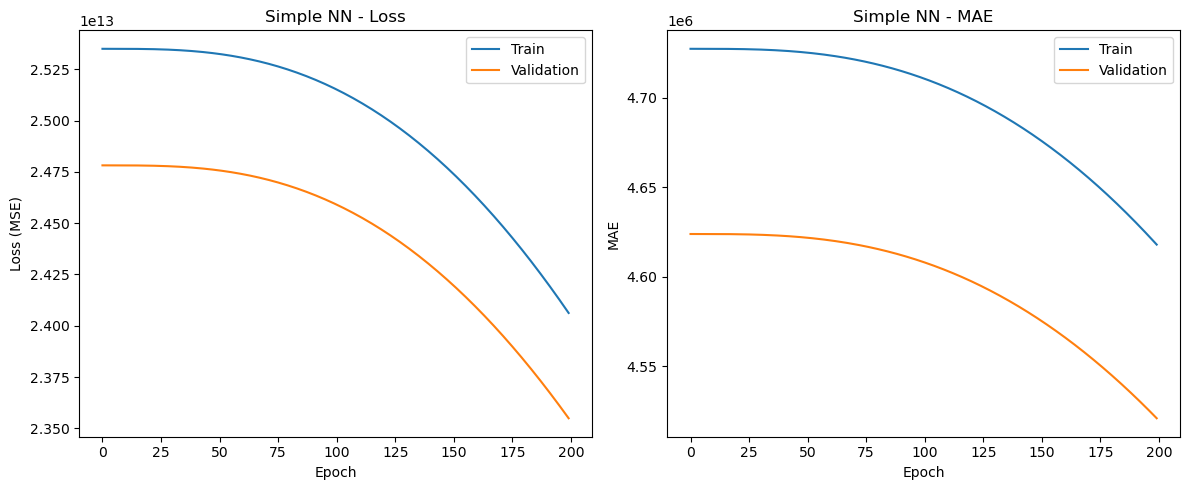


Training Deep NN...
Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 25171802980352.0000 - mae: 4697343.5000 - val_loss: 24781585907712.0000 - val_mae: 4623896.0000 - learning_rate: 0.0010
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171782008832.0000 - mae: 4697342.0000 - val_loss: 24781558644736.0000 - val_mae: 4623893.0000 - learning_rate: 0.0010
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171746357248.0000 - mae: 4697338.5000 - val_loss: 24781491535872.0000 - val_mae: 4623886.5000 - learning_rate: 0.0010
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171666665472.0000 - mae: 4697330.5000 - val_loss: 24781348929536.0000 - val_mae: 4623872.0000 - learning_rate: 0.0010
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171488407552.0000 - mae: 4697312.0000 - val_loss: 24781036453888.0000 - val_mae: 4623841.5000 - learning_rate: 0.0010
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171108823040.0000 - ma

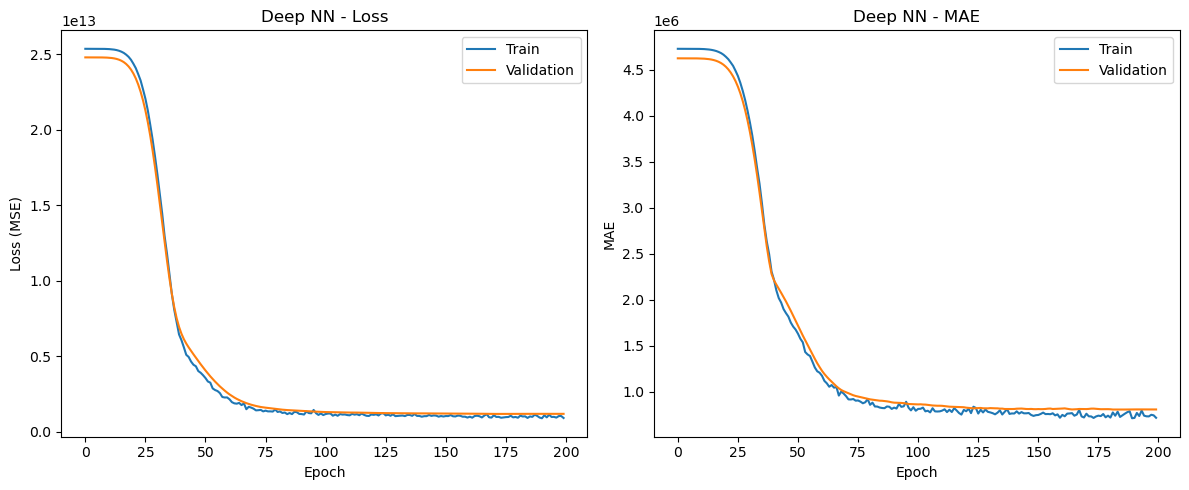


Training NN with BatchNorm...
Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 25171805077504.0000 - mae: 4697344.5000 - val_loss: 24781600587776.0000 - val_mae: 4623898.0000 - learning_rate: 0.0010
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171798786048.0000 - mae: 4697344.5000 - val_loss: 24781598490624.0000 - val_mae: 4623898.0000 - learning_rate: 0.0010
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25171794591744.0000 - mae: 4697344.5000 - val_loss: 24781598490624.0000 - val_mae: 4623898.0000 - learning_rate: 0.0010
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171788300288.0000 - mae: 4697344.0000 - val_loss: 24781594296320.0000 - val_mae: 4623897.5000 - learning_rate: 0.0010
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171784105984.0000 - mae: 4697344.0000 - val_loss: 24781590102016.0000 - val_mae: 4623897.0000 - learning_rate: 0.0010
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25171784105984

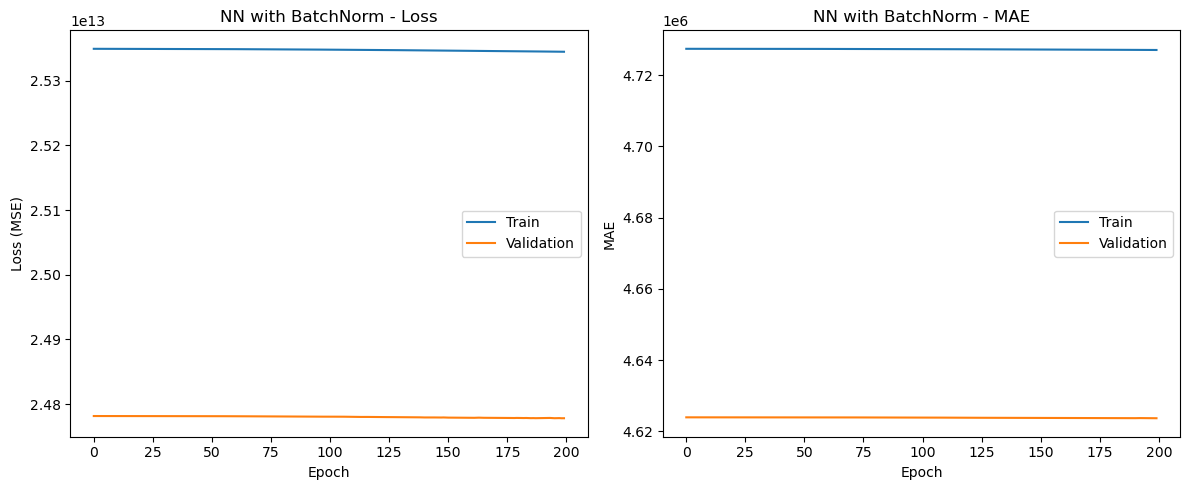


Training Wide NN...
Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25171802980352.0000 - mae: 4697343.5000 - val_loss: 24781579616256.0000 - val_mae: 4623895.5000 - learning_rate: 0.0010
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171771523072.0000 - mae: 4697340.5000 - val_loss: 24781514604544.0000 - val_mae: 4623888.5000 - learning_rate: 0.0010
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171689734144.0000 - mae: 4697332.0000 - val_loss: 24781348929536.0000 - val_mae: 4623872.5000 - learning_rate: 0.0010
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171482116096.0000 - mae: 4697312.0000 - val_loss: 24780975636480.0000 - val_mae: 4623836.5000 - learning_rate: 0.0010
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25171031228416.0000 - mae: 4697268.0000 - val_loss: 24780222758912.0000 - val_mae: 4623764.5000 - learning_rate: 0.0010
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25170150424576.0000 - ma

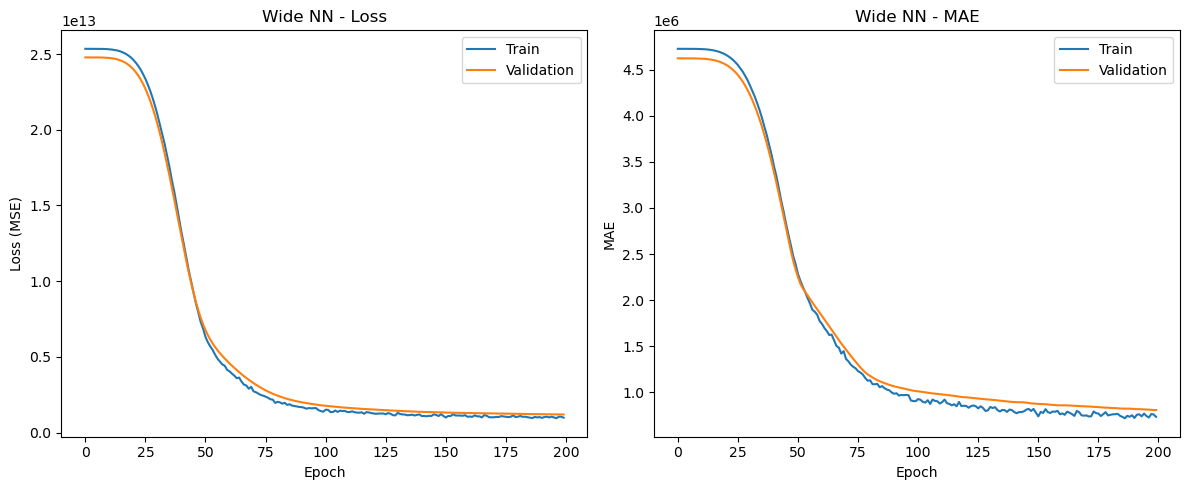

In [22]:
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    results[name] = build_and_evaluate_model(name, model)

In [23]:
print("\n----- Model Comparison -----")
metrics = {}
for name, result in results.items():
    print(f"{name}:")
    print(f"  Train RMSE: {result['train_rmse']:,.2f}")
    print(f"  Test RMSE: {result['test_rmse']:,.2f}")
    print(f"  Train R²: {result['train_r2']:.4f}")
    print(f"  Test R²: {result['test_r2']:.4f}")
    metrics[name] = result['test_rmse']


----- Model Comparison -----
Simple NN:
  Train RMSE: 4,894,019.77
  Test RMSE: 5,349,146.30
  Train R²: -6.7679
  Test R²: -4.6609
Deep NN:
  Train RMSE: 944,032.76
  Test RMSE: 1,383,842.23
  Train R²: 0.7110
  Test R²: 0.6211
NN with BatchNorm:
  Train RMSE: 5,022,998.94
  Test RMSE: 5,488,647.76
  Train R²: -7.1827
  Test R²: -4.9600
Wide NN:
  Train RMSE: 965,296.41
  Test RMSE: 1,413,114.81
  Train R²: 0.6978
  Test R²: 0.6049


In [24]:
best_model_name = min(metrics, key=metrics.get)
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['test_preds']
print(f"\nBest model: {best_model_name} with Test RMSE: {metrics[best_model_name]:,.2f}")


Best model: Deep NN with Test RMSE: 1,383,842.23


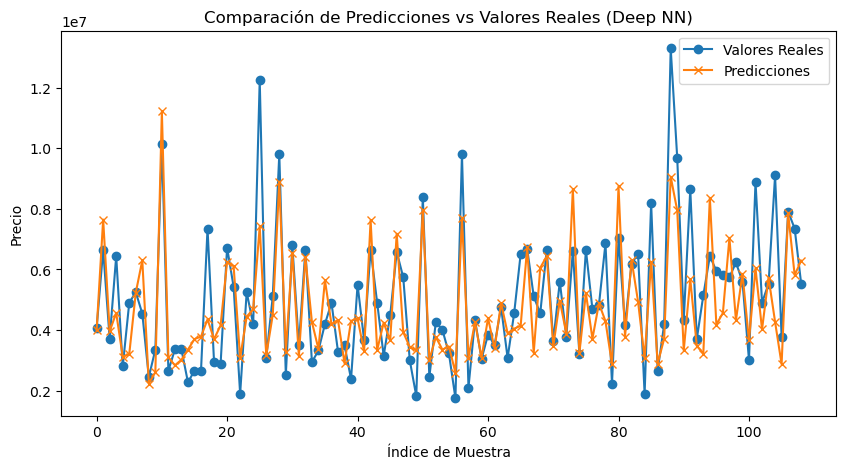

In [25]:
plt.figure(figsize=(10,5))
plt.plot(y_test_original, label='Valores Reales', marker='o')
plt.plot(best_predictions, label='Predicciones', marker='x')
plt.xlabel('Índice de Muestra')
plt.ylabel('Precio')
plt.title(f'Comparación de Predicciones vs Valores Reales ({best_model_name})')
plt.legend()
plt.show()

### Australia electricity demand

In [27]:
def load_and_concatenate_data(folder_path):
    """
    Load and concatenate all CSV files from the specified folder
    """
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    print(f"Found {len(all_files)} CSV files in {folder_path}")
    
    df_list = []
    
    for file in all_files:
        df = pd.read_csv(file)
        print(f"Loaded {file}, shape: {df.shape}")
        df_list.append(df)
    
    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Combined dataframe shape: {combined_df.shape}")
    
    return combined_df

In [28]:
def preprocess_time_series(df):
    """
    Preprocess the time series data for analysis
    """
    processed_df = df.copy()
    
    processed_df['SETTLEMENTDATE'] = pd.to_datetime(processed_df['SETTLEMENTDATE'])
    
    processed_df = processed_df.sort_values('SETTLEMENTDATE')
    
    processed_df.set_index('SETTLEMENTDATE', inplace=True)
    
    missing_values = processed_df.isnull().sum()
    print("\nMissing values in each column:")
    print(missing_values)
    
    if missing_values.sum() > 0:
        print("Filling missing values with forward fill method")
        processed_df = processed_df.fillna(method='ffill')
        processed_df = processed_df.fillna(method='bfill')
    
    processed_df['hour'] = processed_df.index.hour
    processed_df['day_of_week'] = processed_df.index.dayofweek
    processed_df['day_of_month'] = processed_df.index.day
    processed_df['month'] = processed_df.index.month
    processed_df['year'] = processed_df.index.year
    
    processed_df['hour_sin'] = np.sin(2 * np.pi * processed_df.index.hour / 24)
    processed_df['hour_cos'] = np.cos(2 * np.pi * processed_df.index.hour / 24)
    processed_df['day_of_week_sin'] = np.sin(2 * np.pi * processed_df.index.dayofweek / 7)
    processed_df['day_of_week_cos'] = np.cos(2 * np.pi * processed_df.index.dayofweek / 7)
    processed_df['month_sin'] = np.sin(2 * np.pi * processed_df.index.month / 12)
    processed_df['month_cos'] = np.cos(2 * np.pi * processed_df.index.month / 12)

    return processed_df

In [29]:
def create_sequences_for_cnn(data, target_column, sequence_length=24, horizon=1):
    """
    Create sequences for CNN model with a sliding window approach
    
    Parameters:
    - data: DataFrame with features and target
    - target_column: name of the target column
    - sequence_length: number of time steps to use for input sequence
    - horizon: how many steps ahead to predict
    
    Returns:
    - X: sequences of input features (samples, sequence_length, features)
    - y: target values (samples, )
    """
    X = []
    y = []
    
    target_data = data[target_column].values
    
    features_data = data.drop(target_column, axis=1).values
    
    for i in range(len(data) - sequence_length - horizon + 1):
        X.append(features_data[i:(i + sequence_length), :])
        
        y.append(target_data[i + sequence_length + horizon - 1])
        
    return np.array(X), np.array(y)

In [30]:
def build_cnn_model(input_shape, dropout_rate=0.2):
    """
    Build a 1D CNN model for time series forecasting
    """
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [31]:
def plot_training_history(history):
    """
    Plot the training and validation loss and metrics
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train')
    plt.plot(history.history['val_mae'], label='Validation')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [32]:
def evaluate_and_visualize(model, X_test, y_test, scaler_y, test_dates=None):
    """
    Evaluate the model and visualize predictions vs actual values
    """
    y_pred = model.predict(X_test)
    
    if scaler_y is not None:
        y_pred_reshaped = y_pred.reshape(-1, 1)
        y_test_reshaped = y_test.reshape(-1, 1)
        
        y_pred = scaler_y.inverse_transform(y_pred_reshaped).flatten()
        y_test = scaler_y.inverse_transform(y_test_reshaped).flatten()
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Test MAE: {mae:.2f}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test R²: {r2:.4f}")
    
    plt.figure(figsize=(12, 6))
    
    if test_dates is not None:
        plt.plot(test_dates, y_test, label='Actual', marker='o', markersize=3)
        plt.plot(test_dates, y_pred, label='Predicted', marker='x', markersize=3)
        plt.xlabel('Date')
    else:
        plt.plot(y_test, label='Actual', marker='o', markersize=3)
        plt.plot(y_pred, label='Predicted', marker='x', markersize=3)
        plt.xlabel('Sample Index')
    
    plt.ylabel('Electricity Demand')
    plt.title('Actual vs Predicted Electricity Demand')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted (Scatter)')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'y_pred': y_pred}

Found 66 CSV files in ds2
Loaded ds2/PRICE_AND_DEMAND_202207_NSW1.csv, shape: (8928, 5)
Loaded ds2/PRICE_AND_DEMAND_202206_NSW1.csv, shape: (8640, 5)
Loaded ds2/PRICE_AND_DEMAND_201904_NSW1.csv, shape: (1440, 5)
Loaded ds2/PRICE_AND_DEMAND_201905_NSW1.csv, shape: (1488, 5)
Loaded ds2/PRICE_AND_DEMAND_202305_NSW1.csv, shape: (8928, 5)
Loaded ds2/PRICE_AND_DEMAND_202304_NSW1.csv, shape: (8640, 5)
Loaded ds2/PRICE_AND_DEMAND_201806_NSW1.csv, shape: (1440, 5)
Loaded ds2/PRICE_AND_DEMAND_201807_NSW1.csv, shape: (1488, 5)
Loaded ds2/PRICE_AND_DEMAND_202109_NSW1.csv, shape: (1440, 5)
Loaded ds2/PRICE_AND_DEMAND_202108_NSW1.csv, shape: (1488, 5)
Loaded ds2/PRICE_AND_DEMAND_202001_NSW1.csv, shape: (1488, 5)
Loaded ds2/PRICE_AND_DEMAND_201912_NSW1.csv, shape: (1488, 5)
Loaded ds2/PRICE_AND_DEMAND_202210_NSW1.csv, shape: (8928, 5)
Loaded ds2/PRICE_AND_DEMAND_202211_NSW1.csv, shape: (8640, 5)
Loaded ds2/PRICE_AND_DEMAND_202103_NSW1.csv, shape: (1488, 5)
Loaded ds2/PRICE_AND_DEMAND_202102_NSW1.csv,

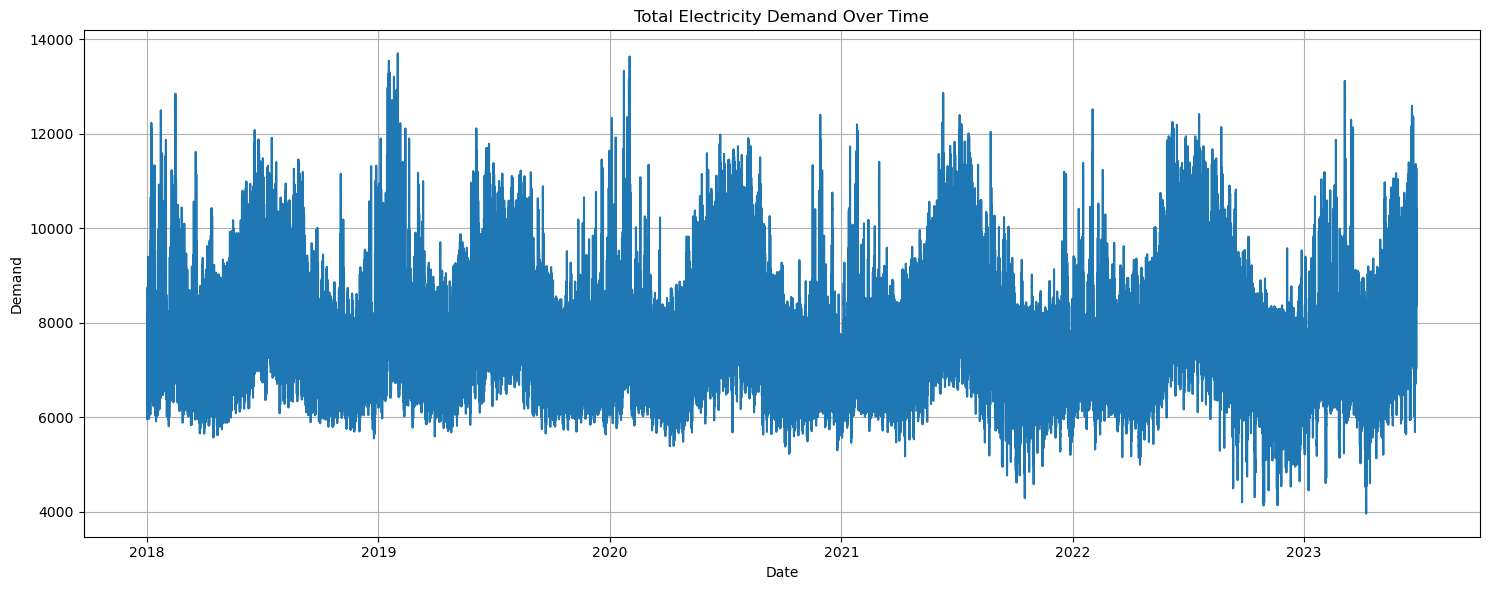


Sequence data shape - X: (248568, 24, 12), y: (248568,)
Train shapes - X: (173997, 24, 12), y: (173997,)
Validation shapes - X: (37285, 24, 12), y: (37285,)
Test shapes - X: (37286, 24, 12), y: (37286,)

---- CNN Model Architecture ----


/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 50)             │        19,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,037 (281.39 KB)

 Trainable params: 71,525 (279.39 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0616 - mae: 0.1281 - val_loss: 0.0039 - val_mae: 0.0456 - learning_rate: 0.0010
Epoch 2/100
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.0047 - mae: 0.0511 - val_loss: 0.0036 - val_mae: 0.0438 - learning_rate: 0.0010
Epoch 3/100
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0039 - mae: 0.0460 - val_loss: 0.0030 - val_mae: 0.0398 - learning_rate: 0.0010
Epoch 4/100
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - loss: 0.0033 - mae: 0.0424 - val_loss: 0.0034 - val_mae: 0.0419 - learning_rate: 0.0010
Epoch 5/100
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.0030 - mae: 0.0404 - val_loss: 0.0035 - val_mae: 0.0429 - learning_rate: 0.0010
Epoch 6/100
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - loss: 0.0027 - mae: 0.0385 - val_loss: 0.0041 - val_mae: 0.0473 - learning_rate: 0.0010
Epoch 7/100
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.0025 - mae: 0.0375 - val_loss: 0.0038 - val_mae: 0.0453 -

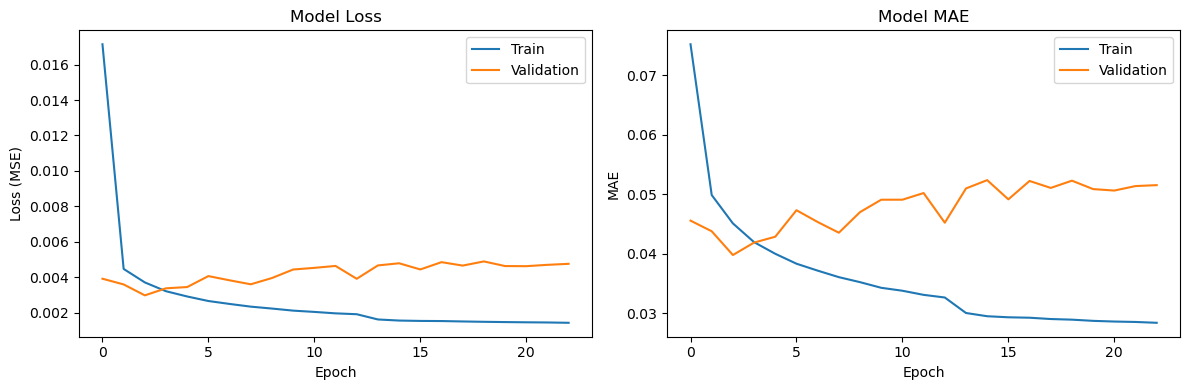


---- Model Evaluation ----
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test MAE: 598.32
Test RMSE: 809.42
Test R²: 0.6070


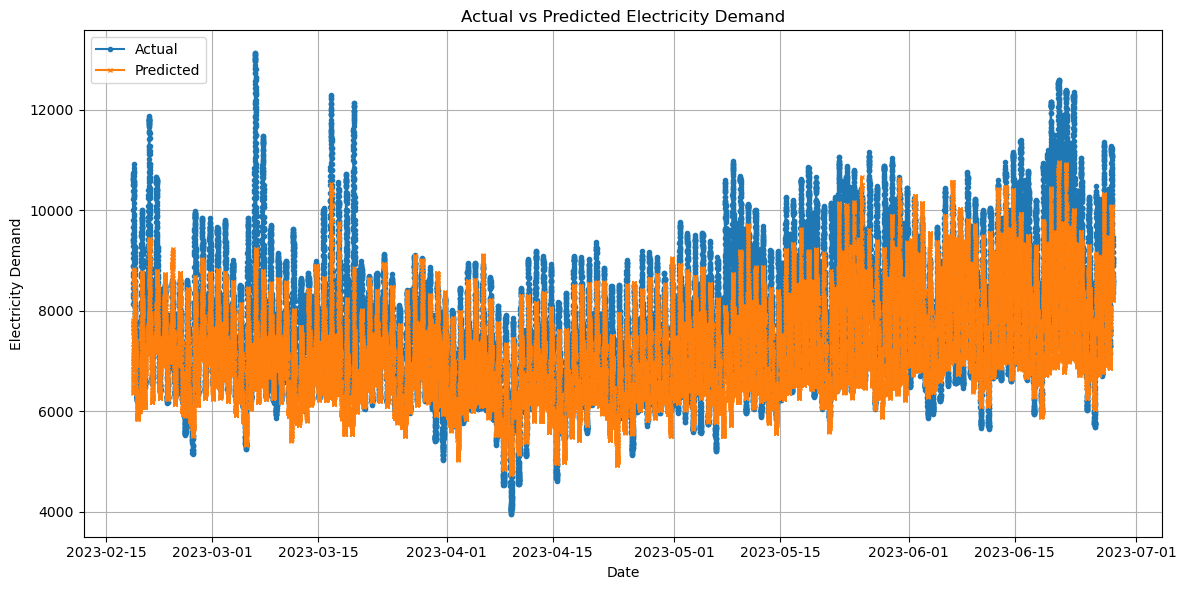

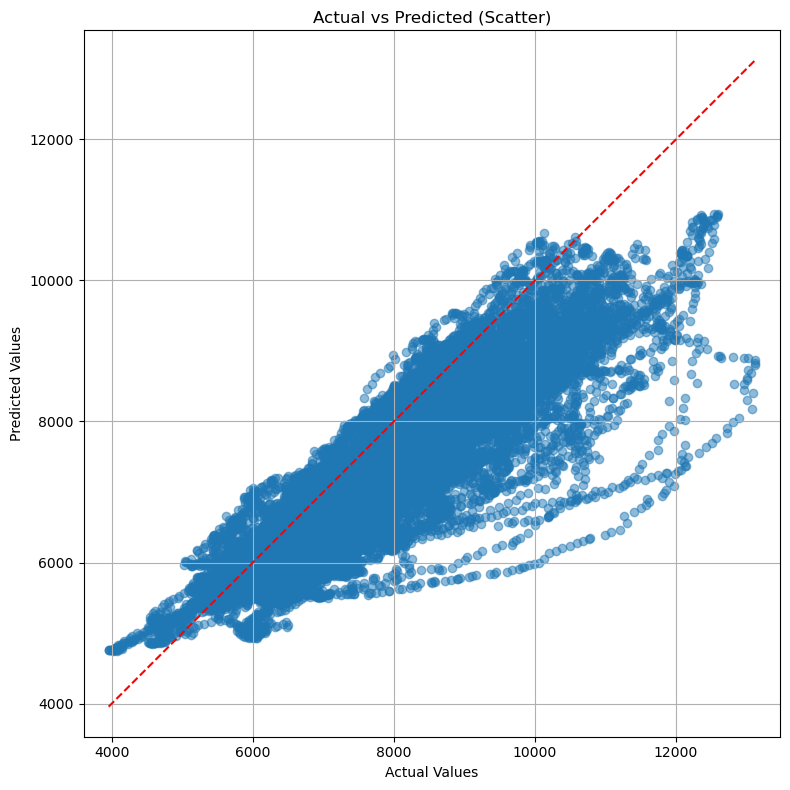

In [33]:
if __name__ == "__main__":
    folder_path = "ds2"
    raw_data = load_and_concatenate_data(folder_path)
    
    print("\nDataset columns:")
    print(raw_data.columns.tolist())
    print("\nSample data:")
    print(raw_data.head())
    
    processed_data = preprocess_time_series(raw_data)
    
    print("\nProcessed data info:")
    print(processed_data.info())
    
    plt.figure(figsize=(15, 6))
    plt.plot(processed_data.index, processed_data['TOTALDEMAND'])
    plt.title('Total Electricity Demand Over Time')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    target_column = 'TOTALDEMAND'
    features = processed_data.drop(columns=[target_column])
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    categorical_columns = features.select_dtypes(include=['object']).columns
    
    features_encoded = pd.get_dummies(features, columns=categorical_columns, drop_first=True)
    
    scaled_features = pd.DataFrame(
        scaler_X.fit_transform(features_encoded),
        index=features.index,
        columns=features_encoded.columns
    )
    
    scaled_target = pd.DataFrame(
        scaler_y.fit_transform(processed_data[[target_column]]),
        index=processed_data.index,
        columns=[target_column]
    )
    
    scaled_data = pd.concat([scaled_features, scaled_target], axis=1)
    
    sequence_length = 24
    forecast_horizon = 1
    
    X_sequences, y_sequences = create_sequences_for_cnn(
        scaled_data, 
        target_column=target_column,
        sequence_length=sequence_length,
        horizon=forecast_horizon
    )
    
    print(f"\nSequence data shape - X: {X_sequences.shape}, y: {y_sequences.shape}")
    
    train_size = int(0.7 * len(X_sequences))
    val_size = int(0.15 * len(X_sequences))
    
    X_train = X_sequences[:train_size]
    y_train = y_sequences[:train_size]
    X_val = X_sequences[train_size:train_size+val_size]
    y_val = y_sequences[train_size:train_size+val_size]
    X_test = X_sequences[train_size+val_size:]
    y_test = y_sequences[train_size+val_size:]
    
    print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
    print(f"Validation shapes - X: {X_val.shape}, y: {y_val.shape}")
    print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    cnn_model = build_cnn_model(input_shape)
    
    print("\n---- CNN Model Architecture ----")
    cnn_model.summary()
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2,
            patience=10, 
            min_lr=0.00001,
            verbose=1
        )
    ]
    
    history = cnn_model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    plot_training_history(history)
    
    print("\n---- Model Evaluation ----")
    
    original_dates = processed_data.index[sequence_length + forecast_horizon - 1:]
    test_dates = original_dates[train_size+val_size:]
    
    results = evaluate_and_visualize(cnn_model, X_test, y_test, scaler_y, test_dates)